In [ ]:
from google.colab import drive
drive.mount('/content/drive',)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

drive_path = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets'

df = pd.read_csv( drive_path + '/train.csv')
df.head()


,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,10,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,10,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,10,SR2021


In [ ]:
df['extent'] = df['extent'].astype(int)/10.0
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0.0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0.0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,0.0,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,0.0,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,0.0,SR2021


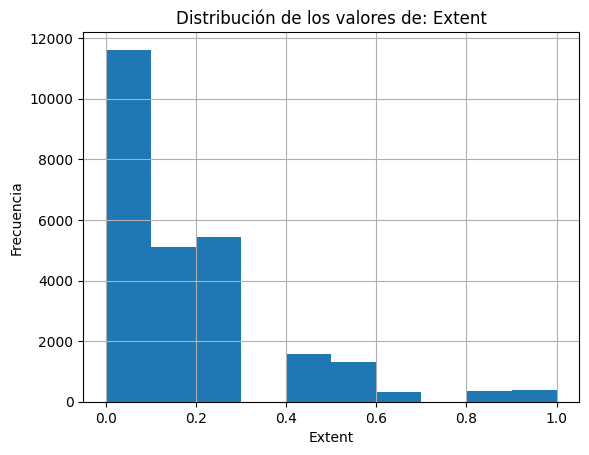

In [ ]:
import matplotlib.pyplot as plt

df['extent'].hist()
plt.title('Distribución de los valores de: Extent')
plt.xlabel('Extent')
plt.ylabel('Frecuencia')
plt.show()


# Modelos Clasificatorios

In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import shutil


image_dir = drive_path + '/train'

In [ ]:

# destination = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets/train'
# for _, row in df.iterrows():
#   image_filename = row['filename']
#   class_label = int(row['extent'])
#   image_source_path = os.path.join(image_dir + '/', image_filename)
#   class_dir = os.path.join(destination, str(class_label))
#   image_destination_path = os.path.join(class_dir, image_filename)
#   if os.path.exists(image_source_path):
#         os.makedirs(class_dir, exist_ok=True)
#         shutil.copy(image_source_path, image_destination_path)
#   else:
#       print(f"Image not found: {image_source_path}")


In [ ]:
import pathlib

# Create a Path object for the directory
dir_path = pathlib.Path(image_dir)

# Use glob to list all files in the directory
files = list(dir_path.glob('*.jpg'))

# Count the number of files
file_count = len(files)

print("Number of files in the directory:", file_count)

Number of files in the directory: 17804


## Creando Datasets

In [ ]:
batch_size = 96
img_height = 180
img_width = 180


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 15432 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 3857 files for validation.


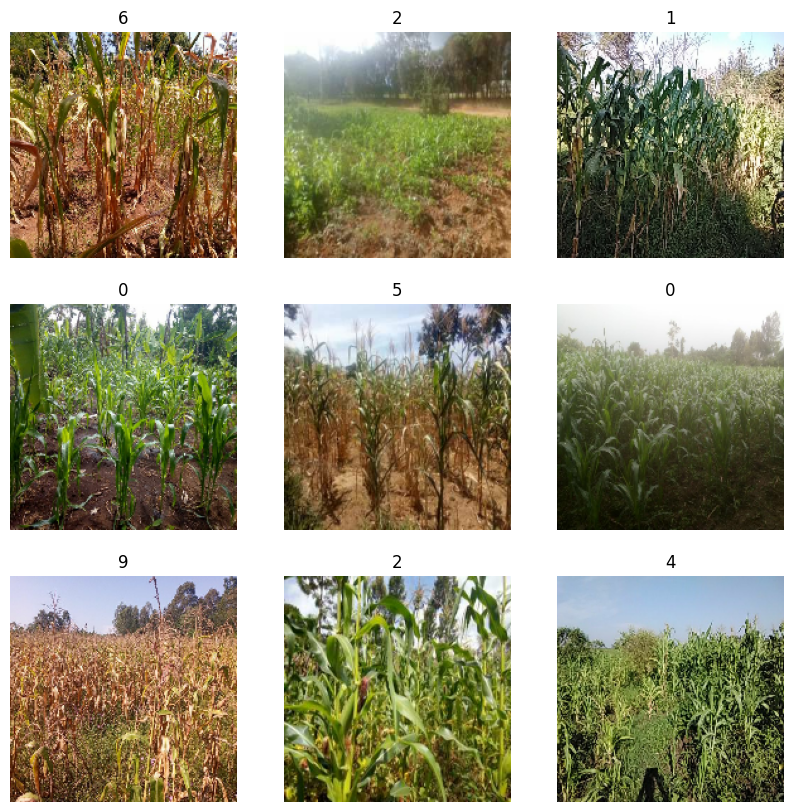

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(96, 180, 180, 3)
(96,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creando un modelo

In [ ]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Convertir valores RGB 0 - 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
epochs=2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2


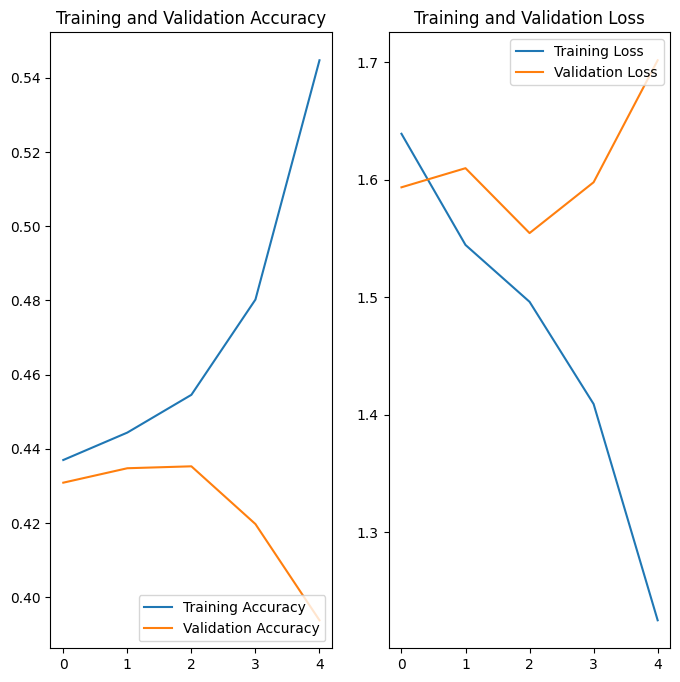

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
epochs=5
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)]


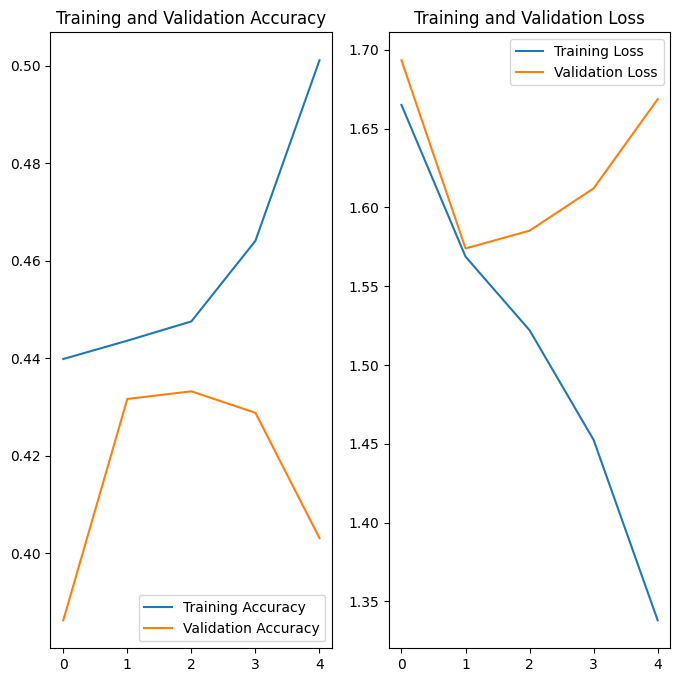

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D


In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_resnet.trainable = False

In [ ]:
model3 = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history3 = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/5
483/483 [==============================] - 54s 111ms/step - loss: 1.6571 - accuracy: 0.4392 - val_loss: 1.6073 - val_accuracy: 0.4361
Epoch 2/5
483/483 [==============================] - 14s 29ms/step - loss: 1.5701 - accuracy: 0.4427 - val_loss: 1.5837 - val_accuracy: 0.4332
Epoch 3/5
483/483 [==============================] - 13s 26ms/step - loss: 1.5143 - accuracy: 0.4506 - val_loss: 1.5829 - val_accuracy: 0.4379
Epoch 4/5
483/483 [==============================] - 13s 27ms/step - loss: 1.4425 - accuracy: 0.4679 - val_loss: 1.5975 - val_accuracy: 0.4179
Epoch 5/5
483/483 [==============================] - 13s 27ms/step - loss: 1.3083 - accuracy: 0.5104 - val_loss: 1.6672 - val_accuracy: 0.3941


In [ ]:
history4 = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)])


Epoch 1/5
483/483 [==============================] - 14s 29ms/step - loss: 1.0985 - accuracy: 0.5927 - val_loss: 1.9492 - val_accuracy: 0.3863
Epoch 2/5
483/483 [==============================] - 14s 28ms/step - loss: 0.8428 - accuracy: 0.6855 - val_loss: 2.0644 - val_accuracy: 0.3915
Epoch 3/5
483/483 [==============================] - 13s 27ms/step - loss: 0.5967 - accuracy: 0.7818 - val_loss: 2.8124 - val_accuracy: 0.3803
Epoch 4/5
483/483 [==============================] - 14s 28ms/step - loss: 0.4174 - accuracy: 0.8521 - val_loss: 3.5245 - val_accuracy: 0.3879
Epoch 4: early stopping


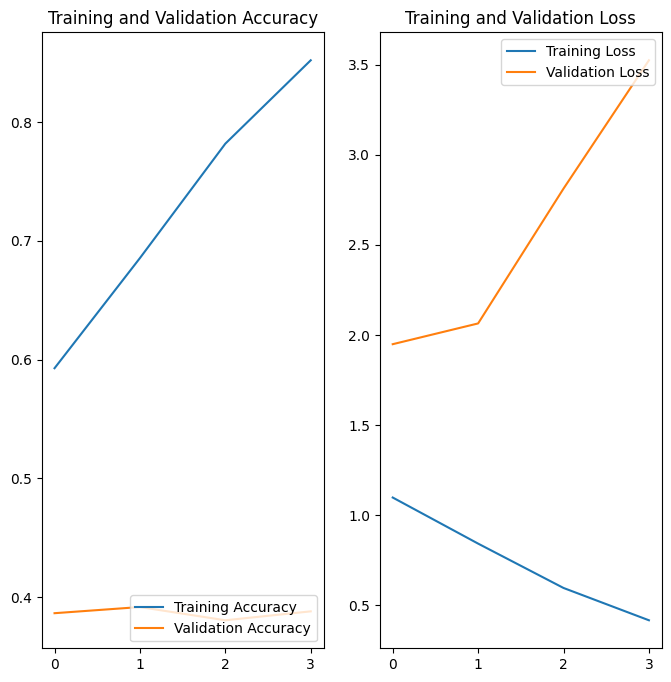

In [ ]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Modelo de regresión
1. Transformar el csv 0 - 1
2. Obtener imagenes
3. Crear valores Y para cada imagen
4. Crear el modelo
5. Entrenar el modelo
6. Comparar resultados

## 1. Transformar csv 0 - 1

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/Shareddrives/Data Science Proyecto 2/DataSets'

df = pd.read_csv( drive_path + '/train.csv')
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,10,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,10,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,10,SR2021


In [ ]:
df['extent'] = df['extent'].astype(int)/100.0
df.head()

,filename,growth_stage,damage,extent,season
0,L398F01276C01S07896Rp26856.jpg,F,DR,0.0,LR2021
1,L355F02268C02S08916Rp30595.jpg,F,DR,0.0,LR2021
2,L134F00879C39S14248Rp42482.jpg,F,DR,0.1,SR2021
3,L1095F01359C01S08260Rp24587.jpg,F,DR,0.1,LR2021
4,L134F00777C39S14171Rp45993.jpg,F,DR,0.1,SR2021


In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import shutil


image_dir = drive_path + '/train'

## Obtener imágenes

In [ ]:
import pathlib

# Create a Path object for the directory
dir_path = pathlib.Path(image_dir)

# Use glob to list all files in the directory
files = list(dir_path.glob('*.*'))

# Count the number of files
file_count = len(files)

print("Number of files in the directory:", file_count)

Number of files in the directory: 19292


In [ ]:
img_height=64
img_width=64
batch_size=32
train_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  seed=123,
  image_size=(img_height, img_width),
  validation_split=0.2,
  subset="training",
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 15432 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19289 files belonging to 11 classes.
Using 3857 files for validation.


In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error',])
history_linear = model.fit(train_ds, epochs=4, validation_data=val_ds)


Epoch 1/4
483/483 [==============================] - 1014s 2s/step - loss: 18566.4902 - mean_squared_error: 18566.4902 - mean_absolute_error: 49.1370 - val_loss: 927.0121 - val_mean_squared_error: 927.0121 - val_mean_absolute_error: 23.8315
Epoch 2/4
483/483 [==============================] - 183s 374ms/step - loss: 34414.2930 - mean_squared_error: 34414.2930 - mean_absolute_error: 56.7836 - val_loss: 534.9753 - val_mean_squared_error: 534.9753 - val_mean_absolute_error: 17.4787
Epoch 3/4
483/483 [==============================] - 179s 366ms/step - loss: 246.4620 - mean_squared_error: 246.4620 - mean_absolute_error: 12.2903 - val_loss: 960.7333 - val_mean_squared_error: 960.7333 - val_mean_absolute_error: 25.7158
Epoch 4/4
483/483 [==============================] - 181s 371ms/step - loss: 273.8466 - mean_squared_error: 273.8466 - mean_absolute_error: 13.0060 - val_loss: 849.4328 - val_mean_squared_error: 849.4328 - val_mean_absolute_error: 24.4654


In [ ]:
for epoch in range(len(history_linear.history['loss'])):
    print(f"Epoch {epoch+1}")
    print(f"Training loss: {history_linear.history['loss'][epoch]}")
    print(f"Validation loss: {history_linear.history['val_loss'][epoch]}\n")


Epoch 1
Training loss: 18566.490234375
Validation loss: 927.0121459960938

Epoch 2
Training loss: 34414.29296875
Validation loss: 534.9752807617188

Epoch 3
Training loss: 246.4619598388672
Validation loss: 960.7332763671875

Epoch 4
Training loss: 273.8465881347656
Validation loss: 849.4328002929688



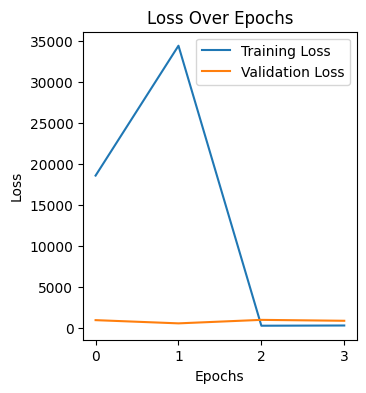

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history_linear.history['loss'], label='Training Loss')
plt.plot(history_linear.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()